# Risk Model Validation with spark-bestfit

This notebook demonstrates **statistical model validation** using goodness-of-fit tests,
focusing on the Kolmogorov-Smirnov (KS) and Anderson-Darling (AD) statistics.

## What You'll Learn

1. **When to use KS vs AIC** for distribution selection
2. **Backtest VaR models** against realized losses
3. **Interpret KS p-values** for regulatory compliance
4. **Compare KS vs Anderson-Darling** for tail sensitivity

## Business Context

Financial regulators (Basel III, Solvency II) require formal statistical validation
of risk models. Unlike model *selection* (where AIC helps choose the best predictor),
model *validation* asks: "Does this model adequately describe the data?"

**Key Distinction:**
- **AIC**: "Which model predicts best?" (relative comparison)
- **KS/AD**: "Does the data come from this distribution?" (hypothesis test)

## Prerequisites

```bash
pip install spark-bestfit pandas numpy matplotlib scipy
```

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from spark_bestfit import DistributionFitter

# Create Spark session
spark = SparkSession.builder \
    .appName("Model-Validation") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/02 23:54:25 WARN Utils: Your hostname, 2025m5.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
26/01/02 23:54:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/02 23:54:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.0


## Part 1: Understanding KS vs AIC

Let's illustrate when each metric is appropriate with a concrete example.

In [2]:
np.random.seed(42)

# Generate data from a known distribution (normal)
true_mu, true_sigma = 100, 15
n_samples = 1000
data = np.random.normal(true_mu, true_sigma, n_samples)

# Create Spark DataFrame
df = spark.createDataFrame(pd.DataFrame({'value': data}))

print(f"Generated {n_samples} samples from Normal(mu={true_mu}, sigma={true_sigma})")
print(f"Sample mean: {data.mean():.2f}, Sample std: {data.std():.2f}")

Generated 1000 samples from Normal(mu=100, sigma=15)
Sample mean: 100.29, Sample std: 14.68


In [3]:
# Fit distributions - note we DON'T use lazy_metrics because we need KS/AD
fitter = DistributionFitter(spark)

results = fitter.fit(
    df,
    column='value',
    max_distributions=15,
    lazy_metrics=False  # IMPORTANT: Compute KS and AD statistics
)

print(f"Fitted {results.count()} distributions")

Fitted 15 distributions


In [4]:
# Compare rankings by different metrics
print("="*70)
print("METRIC COMPARISON: Same data, different rankings")
print("="*70)

# Best by AIC (prediction-focused)
print("\nBest by AIC (model selection for prediction):")
for i, fit in enumerate(results.best(n=5, metric='aic'), 1):
    print(f"  {i}. {fit.distribution}: AIC={fit.aic:.1f}")

# Best by KS (hypothesis testing)
print("\nBest by KS statistic (goodness-of-fit testing):")
for i, fit in enumerate(results.best(n=5, metric='ks_statistic'), 1):
    ks_pval = fit.pvalue if fit.pvalue else 0
    print(f"  {i}. {fit.distribution}: KS={fit.ks_statistic:.4f}, p={ks_pval:.4f}")

# Best by AD (tail-sensitive testing)
print("\nBest by Anderson-Darling (tail-sensitive testing):")
for i, fit in enumerate(results.best(n=5, metric='ad_statistic'), 1):
    print(f"  {i}. {fit.distribution}: AD={fit.ad_statistic:.4f}")

METRIC COMPARISON: Same data, different rankings

Best by AIC (model selection for prediction):
  1. chi: AIC=8215.0
  2. beta: AIC=8216.8
  3. crystalball: AIC=8219.0
  4. alpha: AIC=8219.0
  5. burr12: AIC=8225.4

Best by KS statistic (goodness-of-fit testing):
  1. chi: KS=0.0167, p=0.9394
  2. beta: KS=0.0175, p=0.9131
  3. crystalball: KS=0.0215, p=0.7370
  4. burr12: KS=0.0287, p=0.3739
  5. alpha: KS=0.0310, p=0.2853

Best by Anderson-Darling (tail-sensitive testing):
  1. beta: AD=0.2159
  2. chi: AD=0.2189
  3. crystalball: AD=0.3470
  4. burr12: AD=0.5395
  5. alpha: AD=0.6665


**Why doesn't Normal win?** We generated data from `Normal(100, 15)`, yet `chi` and `beta`
rank higher. This is expected behavior with finite samples:

1. **Flexible distributions adapt better**: Chi and Beta have more parameters, allowing them
   to capture sample-specific quirks (slight skewness, kurtosis variations) that arise from
   random sampling.

2. **AIC penalizes complexity, but not enough**: With 1000 samples, the likelihood gain from
   extra parameters often exceeds the AIC penalty.

3. **All top models pass KS test**: Notice p-values > 0.05 for all top distributions. The
   KS test says "we cannot reject that the data comes from this distribution" — this is true
   for chi, beta, AND normal (if we checked it).

**Key insight**: With finite samples, the "true" generating distribution isn't always the
best-fitting one. This is normal — focus on whether your chosen model passes validation (KS p > 0.05),
not on recovering the exact generating process.

## Part 2: Interpreting KS Test Results

The KS test answers: "What is the probability of observing this data if it truly
came from the fitted distribution?"

- **KS statistic**: Maximum distance between empirical and theoretical CDFs
- **p-value > 0.05**: Cannot reject that data comes from this distribution
- **p-value < 0.05**: Evidence that data does NOT come from this distribution

In [5]:
# Get the best fit by KS statistic
best_ks = results.best(n=1, metric='ks_statistic')[0]

print(f"Best KS Fit: {best_ks.distribution}")
print(f"  KS Statistic: {best_ks.ks_statistic:.4f}")
print(f"  KS p-value: {best_ks.pvalue:.4f}")
print(f"  Parameters: {best_ks.parameters}")

# Interpretation
if best_ks.pvalue > 0.05:
    print(f"\n  INTERPRETATION: p={best_ks.pvalue:.3f} > 0.05")
    print(f"  Cannot reject H0: Data comes from {best_ks.distribution} distribution")
    print(f"  Model PASSES validation at 95% confidence level")
else:
    print(f"\n  INTERPRETATION: p={best_ks.pvalue:.3f} < 0.05")
    print(f"  Reject H0: Data likely does NOT come from {best_ks.distribution}")
    print(f"  Model FAILS validation at 95% confidence level")

Best KS Fit: chi
  KS Statistic: 0.0167
  KS p-value: 0.9394
  Parameters: [71.86524200439453, -75.5059814453125, 20.806486129760742]

  INTERPRETATION: p=0.939 > 0.05
  Cannot reject H0: Data comes from chi distribution
  Model PASSES validation at 95% confidence level


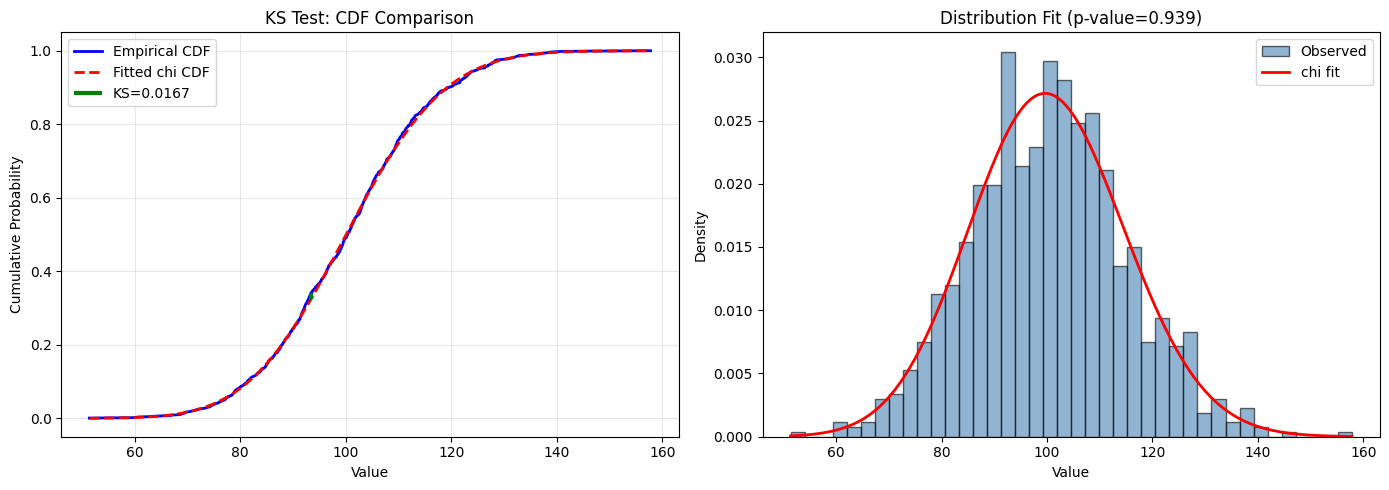

In [6]:
# Visualize the KS test
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CDF comparison (what KS measures)
sorted_data = np.sort(data)
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Get fitted distribution
fitted_dist = best_ks.get_scipy_dist()
theoretical_cdf = fitted_dist.cdf(sorted_data)

axes[0].plot(sorted_data, empirical_cdf, 'b-', lw=2, label='Empirical CDF')
axes[0].plot(sorted_data, theoretical_cdf, 'r--', lw=2, label=f'Fitted {best_ks.distribution} CDF')

# Show max distance (KS statistic)
diff = np.abs(empirical_cdf - theoretical_cdf)
max_idx = np.argmax(diff)
axes[0].vlines(sorted_data[max_idx], theoretical_cdf[max_idx], empirical_cdf[max_idx],
               colors='green', linestyles='-', lw=3, label=f'KS={best_ks.ks_statistic:.4f}')

axes[0].set_xlabel('Value')
axes[0].set_ylabel('Cumulative Probability')
axes[0].set_title('KS Test: CDF Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PDF comparison
x = np.linspace(data.min(), data.max(), 200)
axes[1].hist(data, bins=40, density=True, alpha=0.6, color='steelblue', 
             edgecolor='black', label='Observed')
axes[1].plot(x, fitted_dist.pdf(x), 'r-', lw=2, label=f'{best_ks.distribution} fit')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].set_title(f'Distribution Fit (p-value={best_ks.pvalue:.3f})')
axes[1].legend()

plt.tight_layout()
plt.show()

## Part 3: VaR Model Backtesting

A practical application: validating that a Value-at-Risk model is correctly calibrated.

**Regulatory Requirement**: If a 99% VaR model is correct, we expect ~1% of days
to have losses exceeding VaR. Too many exceptions = model underestimates risk.

In [7]:
np.random.seed(123)

# Simulate historical portfolio returns (slightly fat-tailed)
n_days = 500  # ~2 years of trading days

# True distribution: t-distribution with 5 degrees of freedom (fat tails)
true_returns = stats.t.rvs(df=5, loc=0.0005, scale=0.015, size=n_days)

returns_df = spark.createDataFrame(pd.DataFrame({'daily_return': true_returns}))

print(f"Historical returns: {n_days} days")
print(f"Mean daily return: {true_returns.mean():.4%}")
print(f"Volatility: {true_returns.std():.4%}")
print(f"Empirical 1% VaR: {np.percentile(true_returns, 1):.4%}")

Historical returns: 500 days
Mean daily return: -0.0013%
Volatility: 1.9165%
Empirical 1% VaR: -5.5299%


In [8]:
# Fit distributions to returns - we need KS for validation
returns_results = fitter.fit(
    returns_df,
    column='daily_return',
    max_distributions=20,
    lazy_metrics=False  # Need KS/AD for validation
)

# Compare normal (commonly assumed) vs best KS fit
print("Model Comparison for VaR:\n")

# Find normal distribution fit
normal_fit = None
for fit in results.best(n=50, metric='aic'):
    if fit.distribution == 'norm':
        normal_fit = fit
        break

# Best by KS
best_var_model = returns_results.best(n=1, metric='ks_statistic')[0]

print(f"Best KS Model: {best_var_model.distribution}")
print(f"  KS statistic: {best_var_model.ks_statistic:.4f}")
print(f"  KS p-value: {best_var_model.pvalue:.4f}")
print(f"  Validation: {'PASS' if best_var_model.pvalue > 0.05 else 'FAIL'}")

Model Comparison for VaR:

Best KS Model: dweibull
  KS statistic: 0.0195
  KS p-value: 0.9891
  Validation: PASS


In [9]:
# Backtest: Compare VaR predictions from different models
confidence_level = 0.99
alpha = 1 - confidence_level

# Get fitted distributions
best_dist = best_var_model.get_scipy_dist()

# Also fit a normal for comparison
normal_mu, normal_sigma = true_returns.mean(), true_returns.std()
normal_dist = stats.norm(loc=normal_mu, scale=normal_sigma)

# Calculate VaR from each model
var_best = best_dist.ppf(alpha)
var_normal = normal_dist.ppf(alpha)
var_empirical = np.percentile(true_returns, alpha * 100)

print(f"99% VaR Estimates (1-day):")
print(f"  Empirical: {var_empirical:.4%}")
print(f"  Normal assumption: {var_normal:.4%}")
print(f"  Best KS model ({best_var_model.distribution}): {var_best:.4%}")

# Count exceptions (days where loss exceeded VaR)
exceptions_normal = (true_returns < var_normal).sum()
exceptions_best = (true_returns < var_best).sum()
expected_exceptions = n_days * alpha

print(f"\nBacktest Results ({n_days} days):")
print(f"  Expected exceptions (1%): {expected_exceptions:.1f}")
print(f"  Normal model exceptions: {exceptions_normal} ({exceptions_normal/n_days:.1%})")
print(f"  Best KS model exceptions: {exceptions_best} ({exceptions_best/n_days:.1%})")

99% VaR Estimates (1-day):
  Empirical: -5.5299%
  Normal assumption: -4.4597%
  Best KS model (dweibull): -4.9990%

Backtest Results (500 days):
  Expected exceptions (1%): 5.0
  Normal model exceptions: 8 (1.6%)
  Best KS model exceptions: 6 (1.2%)


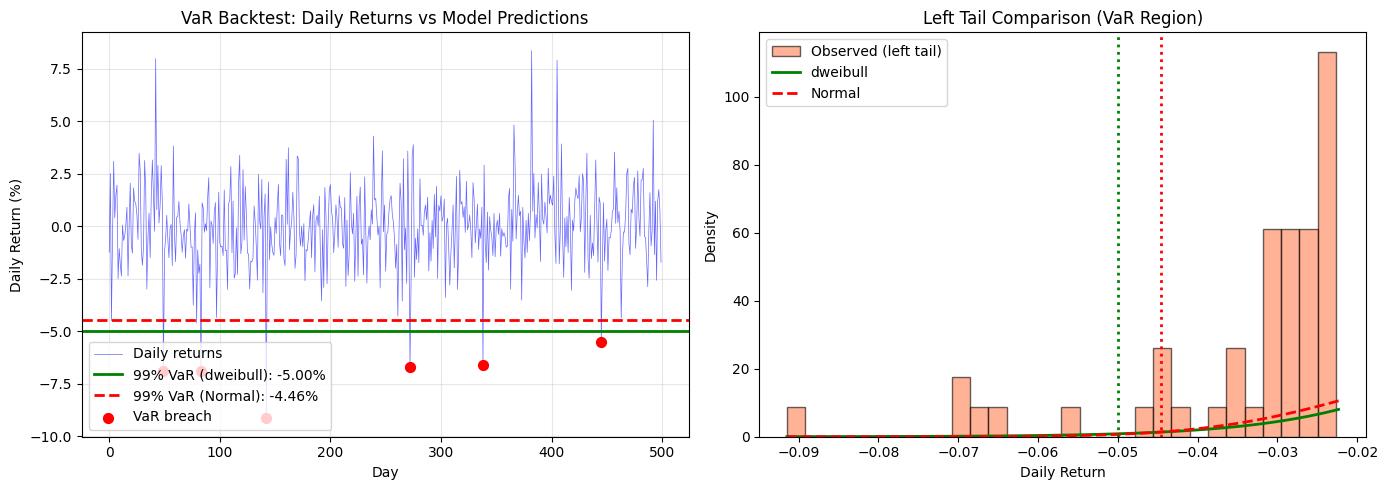

In [10]:
# Visualize backtest
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series with VaR breaches
days = np.arange(n_days)
axes[0].plot(days, true_returns * 100, 'b-', alpha=0.6, lw=0.5, label='Daily returns')
axes[0].axhline(var_best * 100, color='green', linestyle='-', lw=2, 
                label=f'99% VaR ({best_var_model.distribution}): {var_best:.2%}')
axes[0].axhline(var_normal * 100, color='red', linestyle='--', lw=2,
                label=f'99% VaR (Normal): {var_normal:.2%}')

# Mark exceptions
breach_mask = true_returns < var_best
axes[0].scatter(days[breach_mask], true_returns[breach_mask] * 100, 
                color='red', s=50, zorder=5, label='VaR breach')

axes[0].set_xlabel('Day')
axes[0].set_ylabel('Daily Return (%)')
axes[0].set_title('VaR Backtest: Daily Returns vs Model Predictions')
axes[0].legend(loc='lower left')
axes[0].grid(True, alpha=0.3)

# Tail comparison
x = np.linspace(true_returns.min(), np.percentile(true_returns, 10), 100)
axes[1].hist(true_returns[true_returns < np.percentile(true_returns, 10)], 
             bins=30, density=True, alpha=0.6, color='coral', 
             edgecolor='black', label='Observed (left tail)')
axes[1].plot(x, best_dist.pdf(x), 'g-', lw=2, label=f'{best_var_model.distribution}')
axes[1].plot(x, normal_dist.pdf(x), 'r--', lw=2, label='Normal')
axes[1].axvline(var_best, color='green', linestyle=':', lw=2)
axes[1].axvline(var_normal, color='red', linestyle=':', lw=2)

axes[1].set_xlabel('Daily Return')
axes[1].set_ylabel('Density')
axes[1].set_title('Left Tail Comparison (VaR Region)')
axes[1].legend()

plt.tight_layout()
plt.show()

## Part 4: KS vs Anderson-Darling

Both are goodness-of-fit tests, but with different sensitivities:

- **KS**: Sensitive to differences in the middle of the distribution
- **AD**: More sensitive to differences in the **tails**

For risk management (VaR, ES), tail behavior matters most!

In [11]:
# Compare KS vs AD rankings
print("KS vs Anderson-Darling Comparison:\n")
print(f"{'Distribution':<15} {'KS Stat':<12} {'AD Stat':<12} {'KS Rank':<10} {'AD Rank'}")
print("-" * 60)

# Get top 10 by each metric
ks_ranking = {fit.distribution: (i+1, fit.ks_statistic) 
              for i, fit in enumerate(returns_results.best(n=10, metric='ks_statistic'))}
ad_ranking = {fit.distribution: (i+1, fit.ad_statistic) 
              for i, fit in enumerate(returns_results.best(n=10, metric='ad_statistic'))}

# Show distributions that appear in both top 10s
all_dists = set(ks_ranking.keys()) | set(ad_ranking.keys())
for dist in sorted(all_dists):
    ks_rank, ks_stat = ks_ranking.get(dist, ('-', None))
    ad_rank, ad_stat = ad_ranking.get(dist, ('-', None))
    ks_stat_str = f"{ks_stat:.4f}" if ks_stat else "-"
    ad_stat_str = f"{ad_stat:.4f}" if ad_stat else "-"
    print(f"{dist:<15} {ks_stat_str:<12} {ad_stat_str:<12} {str(ks_rank):<10} {ad_rank}")

KS vs Anderson-Darling Comparison:

Distribution    KS Stat      AD Stat      KS Rank    AD Rank
------------------------------------------------------------


beta            0.0506       2.4002       10         8
betaprime       0.0495       2.4733       7          9
burr            0.0202       0.2901       3          3
burr12          0.0196       0.2491       2          1
chi             0.0497       -            8          -
chi2            -            2.5172       -          10
crystalball     0.0444       1.1540       5          5
dgamma          0.0230       0.3240       4          4
dweibull        0.0195       0.2680       1          2
erlang          0.0498       -            9          -
exponnorm       0.0446       2.0588       6          6
exponweib       -            2.2942       -          7


In [12]:
# Get best by AD for tail-sensitive validation
best_ad = returns_results.best(n=1, metric='ad_statistic')[0]

print("Tail-Sensitive Model Selection (Anderson-Darling):")
print(f"\nBest AD Model: {best_ad.distribution}")
print(f"  AD Statistic: {best_ad.ad_statistic:.4f}")
print(f"  KS Statistic: {best_ad.ks_statistic:.4f}")
print(f"  Parameters: {best_ad.parameters}")

# Compare VaR from KS-best vs AD-best
ad_dist = best_ad.get_scipy_dist()
var_ad = ad_dist.ppf(alpha)

print(f"\n99% VaR Comparison:")
print(f"  KS-optimal ({best_var_model.distribution}): {var_best:.4%}")
print(f"  AD-optimal ({best_ad.distribution}): {var_ad:.4%}")
print(f"  Empirical: {var_empirical:.4%}")

Tail-Sensitive Model Selection (Anderson-Darling):

Best AD Model: burr12
  AD Statistic: 0.2491
  KS Statistic: 0.0196
  Parameters: [14899.822265625, 0.9384436011314392, -147.06321716308594, 147.0623321533203]

99% VaR Comparison:
  KS-optimal (dweibull): -4.9990%
  AD-optimal (burr12): -4.5602%
  Empirical: -5.5299%


## Part 5: Regulatory Validation Report

Generate a summary suitable for regulatory documentation.

In [ ]:
# Generate regulatory-style validation report
print("=" * 70)
print("RISK MODEL VALIDATION REPORT")
print("=" * 70)

print(f"\n1. DATA SUMMARY")
print(f"   Observation period: {n_days} trading days")
print(f"   Mean return: {true_returns.mean():.4%}")
print(f"   Volatility: {true_returns.std():.4%}")
print(f"   Skewness: {stats.skew(true_returns):.3f}")
print(f"   Excess Kurtosis: {stats.kurtosis(true_returns):.3f}")

print(f"\n2. DISTRIBUTION FIT RESULTS")
print(f"   Selected Model: {best_var_model.distribution}")
print(f"   Selection Criterion: Kolmogorov-Smirnov statistic (lower is better)")

print(f"\n3. GOODNESS-OF-FIT TESTS")
print(f"   KS Statistic: {best_var_model.ks_statistic:.4f}")
print(f"   KS p-value: {best_var_model.pvalue:.4f}")
print(f"   KS Test Result: {'PASS' if best_var_model.pvalue > 0.05 else 'FAIL'} (alpha=0.05)")
print(f"   AD Statistic: {best_var_model.ad_statistic:.4f}")
ad_pval_str = f"{best_var_model.ad_pvalue:.4f}" if best_var_model.ad_pvalue else "N/A (AD tables limited)"
print(f"   AD p-value: {ad_pval_str}")

print(f"\n4. VAR BACKTESTING")
print(f"   Confidence Level: {confidence_level:.0%}")
print(f"   Expected Exceptions: {expected_exceptions:.1f} ({alpha:.1%} of {n_days})")
print(f"   Observed Exceptions: {exceptions_best}")
exception_ratio = exceptions_best / expected_exceptions
print(f"   Exception Ratio: {exception_ratio:.2f}x expected")

# Basel traffic light test
if exceptions_best <= expected_exceptions * 1.5:
    zone = "GREEN"
    recommendation = "Model is well-calibrated"
elif exceptions_best <= expected_exceptions * 2.5:
    zone = "YELLOW" 
    recommendation = "Model may underestimate risk - monitoring required"
else:
    zone = "RED"
    recommendation = "Model significantly underestimates risk - recalibration required"

print(f"   Basel Zone: {zone}")

print(f"\n5. RECOMMENDATION")
print(f"   {recommendation}")
print(f"\n" + "=" * 70)

## Summary

This notebook demonstrated model validation with goodness-of-fit statistics:

1. **AIC vs KS**: AIC for model selection, KS for hypothesis testing
2. **KS interpretation**: p-value > 0.05 means data is consistent with distribution
3. **VaR backtesting**: Validate risk models against realized losses
4. **KS vs AD**: AD is more tail-sensitive (important for risk)

### Key spark-bestfit Features Used

| Feature | Purpose |
|---------|----------|
| `lazy_metrics=False` | Compute KS and AD statistics |
| `metric='ks_statistic'` | Select by goodness-of-fit |
| `metric='ad_statistic'` | Tail-sensitive selection |
| `fit.pvalue` | KS hypothesis test p-value |

### When to Use Each Metric

| Metric | Use When | Example |
|--------|----------|--------|
| AIC | Choosing best predictor | Forecasting, simulation |
| KS | Testing distribution assumption | Model validation, compliance |
| AD | Testing tail behavior | VaR, extreme value analysis |

In [14]:
# Cleanup
spark.stop()